In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from collections import defaultdict
import re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, mean_squared_error, r2_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import  RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer
from math import sqrt
import scipy.stats as stats
from scipy.stats import zscore

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Import the data and clean it up with all the functions from our EDA

We will be using the string hashing trick to attempt a better fit than our initial methods. For this reason we're going to conform as many of our columns to individual strings as possible, and then turn the row into 1 string for processing with the FeatureHasher.

In [2]:
_2019 = pd.read_csv('../data/IMDB_mine_data_2019.csv',index_col=0)
_2018 = pd.read_csv('../data/IMDB_mine_data_2018.csv',index_col=0)
_2017 = pd.read_csv('../data/IMDB_mine_data_2017.csv',index_col=0)
_2016 = pd.read_csv('../data/IMDB_mine_data_2016.csv',index_col=0)
_2015 = pd.read_csv('../data/IMDB_mine_data_2015.csv',index_col=0)
#get all the films into one DF
films = pd.concat([_2019,_2018,_2017,_2016,_2015])
# remove the filler films we were using to start the mining bot
films = films[films['title_code'] != np.nan]
films = films[films['opening_wknd'] != np.nan]
films = films[films['release_date'] != '1980-05-16']
films.shape

(2965, 26)

In [3]:
#Reset the index now that all films are in 1 dataframe
#films = films.reset_index(drop=True)
films.head(3)

,title,runtime,release_date,rating,prod_co,metaScore,metaUserScore,imdb_rating,genre,actor1,actor2,actor3,actor4,actor5,actor6,actor7,actor8,actor9,actor10,directors,writers,budget,opening_wknd,gross_dom,gross_int,title_code
0,Motherless Brooklyn,0,2019-11-01,R,"['Class 5 Films', 'Warner Bros.']",0,0,0,"['Crime', 'Drama', 'Mystery']",/name/nm0001570/,/name/nm1813221/,/name/nm0000285/,/name/nm0134072/,/name/nm0000353/,/name/nm0000246/,/name/nm0839486/,/name/nm0427728/,/name/nm1316767/,/name/nm0656929/,['Edward Norton'],"['Jonathan Lethem', 'Edward Norton']",26000000.0,3500454.0,9277736.0,18477736.0,tt0385887
0,Alita: Battle Angel,0,2019-02-14,PG-13,"['Twentieth Century Fox', 'Twentieth Century F...",0,0,0,"['Action', 'Adventure', 'Sci-Fi', 'Thriller']",/name/nm4023073/,/name/nm0910607/,/name/nm0000124/,/name/nm0991810/,/name/nm4534098/,/name/nm0355097/,/name/nm5277107/,/name/nm7449863/,/name/nm7093076/,/name/nm1701107/,['Robert Rodriguez'],"['James Cameron', 'Laeta Kalogridis', 'Yukito ...",170000000.0,28525613.0,85710210.0,404852543.0,tt0437086
0,Danger Close,0,2019-11-08,R,"['Deeper Water', 'Saboteur Media', 'Saban Films']",0,0,0,"['Action', 'Drama', 'War']",/name/nm1379938/,/name/nm9826817/,/name/nm1542397/,/name/nm2527406/,/name/nm5937328/,/name/nm9680111/,/name/nm3478396/,/name/nm7011217/,/name/nm2828232/,/name/nm7202582/,['Kriv Stenders'],"['Stuart Beattie', 'James Nicholas', 'Karel Se...",35000000.0,2078370.0,NaN,NaN,tt0441881


#### Clean some of the columns and map the features to a cleaner structure

In [4]:
#clean the text in the production company column, and turn it into an accessable array
films['prod_co'] = films.prod_co.map(lambda x : re.findall(r"'(.*?)'",x, re.DOTALL))

#break production and distribution out into their own columns
films['production'] = films['prod_co'].map(lambda x : x[0] if len(x) >= 1 else np.nan)
films['production_2'] = films['prod_co'].map(lambda x : x[1] if len(x) >= 3 else np.nan)
films['distribution'] = films['prod_co'].map(lambda x : x[-1] if len(x) >= 2 else np.nan)

#convert the release date to a pandas datetime object
films['release_date'] = films['release_date'].map(lambda x : pd.to_datetime(x))

#Set the first director to their own column
films.directors = films.directors.map(lambda x : re.findall(r"'(.*?)'",x, re.DOTALL if isinstance(x, str) else np.nan))
films['director'] = films['directors'].map(lambda x: x[0].replace(" ", '') if len(x) >= 1 else 'none')

#### Add the Actor names from the key we scraped

In [5]:
# convert the actor codes to strings
actor_key = pd.read_csv('../data/actor_key.csv', index_col=0).reset_index()

def get_actor_name(key):
    #print(key)
    if isinstance(key, float):
        return key
    row = actor_key.loc[actor_key['actor'] == key].index[0]
    #print(type(actor_key.iloc[row]['name']), actor_key.iloc[row]['name'])
    return actor_key.iloc[row]['name']

def get_actor_key(name):
    #print(key)
    row = actor_key.loc[actor_key['name'] == name].index[0]
    return(actor_key.iloc[row]['actor'])

In [6]:
films['actor_1'] = films['actor1'].map(lambda x : get_actor_name(x).replace(" ", '') if isinstance(x, str) else None)
films['actor_2'] = films['actor2'].map(lambda x : get_actor_name(x).replace(" ", '') if isinstance(x, str) else None)
films['actor_3'] = films['actor3'].map(lambda x : get_actor_name(x).replace(" ", '') if isinstance(x, str) else None)
films['actor_4'] = films['actor4'].map(lambda x : get_actor_name(x).replace(" ", '') if isinstance(x, str) else None)
films['actor_5'] = films['actor5'].map(lambda x : get_actor_name(x).replace(" ", '') if isinstance(x, str) else None)
films['actor_6'] = films['actor6'].map(lambda x : get_actor_name(x).replace(" ", '') if isinstance(x, str) else None)
films['actor_7'] = films['actor7'].map(lambda x : get_actor_name(x).replace(" ", '') if isinstance(x, str) else None)
films['actor_8'] = films['actor8'].map(lambda x : get_actor_name(x).replace(" ", '') if isinstance(x, str) else None)
films['actor_9'] = films['actor9'].map(lambda x : get_actor_name(x).replace(" ", '') if isinstance(x, str) else None)
films['actor_10'] = films['actor10'].map(lambda x : get_actor_name(x).replace(" ", '') if isinstance(x, str) else None)

#### Merge the producers with their films

In [7]:
#Add the main producer and executive producer to the dataframe
producer_key = pd.read_csv('../data/producer_key.csv', index_col=0)
films = films.merge(producer_key, on='title_code', how='left')
#remove spaces in the names, and replace the fill values with empty strings
films['producer'] = films['producer'].map(lambda x : x.replace(" ", '') if x!='[]' else None)
films['executive'] = films['executive'].map(lambda x : x.replace(" ", '') if x!='[]' else None)

#### Encode the release month as a string column

In [8]:
#reencode the release month as a string.
films['release_month'] = films['release_date'].map(lambda x : pd.to_datetime(x).month)
films['release_month'] = films['release_month'].map(lambda x : 'January' if x == 1 else ( 'February' if x==2 else ( 'March' if x==3 else ( 'April' if x==4 else ('May' if x==5 else ('June' if x==6 else ( 'July' if x==7 else ( 'August' if x==8 else ('September' if x==9 else ( 'October' if x==10 else ( 'November' if x==11 else ('December' if x==12 else 'unknown'))))))))) ) ))
#reencode the release year as a string
films['release_year'] = films['release_date'].map(lambda x : x.year)
films['release_year'] = films['release_year'].map(lambda x : '2015' if x == 2015 else ( '2016' if x==2016 else ( '2017' if x==2017 else ( '2018' if x==2018 else ('2019' if x==2019 else ('2020' if x==2020 else 'none'))))))

#### Add all the strings together to simplify our string hashing

In [9]:
films['train_string'] = films[['production','distribution','director','actor_1','actor_2','actor_3','actor_4',
                               'actor_5','actor_6','actor_7','actor_8','actor_9','actor_10',
                               'producer','executive']].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

# Hashing Features
We are going to create a single matrix that we can train a model on that contains all of the strings in our films.

In [10]:
vectorizer = HashingVectorizer(n_features=1100)
vector = vectorizer.transform(films['train_string'].to_numpy())
vector

<2965x1100 sparse matrix of type '<class 'numpy.float64'>'
	with 47774 stored elements in Compressed Sparse Row format>

#### Train Test split, and train on our string hashing.

In [11]:
y = films['opening_wknd']
X = vector

dum_guess = round(films['opening_wknd'].mean())
print("Base Model will guess: "+ str(dum_guess))
print("Our baseline RMSE is : " + str(round(sqrt(mean_squared_error(y, np.full(y.shape,dum_guess))))))

Base Model will guess: 6284064.0
Our baseline RMSE is : 21204937


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
lin_model = LinearRegression()
lin_model.fit(np.nan_to_num(X_train), y_train)
lin_preds = lin_model.predict(X_test)
print("MSE : " + str(mean_squared_error(y_test, lin_preds)))
print("RMSE: " + str(sqrt(mean_squared_error(y_test, lin_preds))))

MSE : 592690279751323.0
RMSE: 24345231.150090218


In [14]:
rf_model = RandomForestRegressor(n_estimators=550,
                           #max_features=3,
                            max_depth=1000,
                            min_samples_split=3,
                            min_samples_leaf=5)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print("MSE : " + str(mean_squared_error(y_test, rf_pred)))
print("RMSE: " + str(sqrt(mean_squared_error(y_test, rf_pred))))

MSE : 356138358721634.56
RMSE: 18871628.4067283


In [15]:
model_g = GradientBoostingRegressor(learning_rate=0.025,
                                   n_estimators=430,
                                   min_samples_leaf=4,
                                   max_depth=1100)
model_g.fit(X_train,y_train)
preds_gb = model_g.predict(X_test)
print("MSE : " + str(mean_squared_error(y_test, preds_gb)))
print("RMSE: " + str(sqrt(mean_squared_error(y_test, preds_gb))))

MSE : 439298382491479.3
RMSE: 20959446.139902633


In [16]:
xgb_model = xgb.XGBRegressor(n_estimators=100,
                            max_depth=200).fit(X_train, y_train)
xg_pred = xgb_model.predict(X_test)
print("MSE : " + str(mean_squared_error(y_test, xg_pred)))
print("RMSE: " + str(sqrt(mean_squared_error(y_test, xg_pred))))

MSE : 413871197730962.7
RMSE: 20343824.56007136


### Great news!
This means that we have some signal from our string vectors. Now we will add our one-hot features, and the other data points that we discovered in our inital EDA, and see if we can improve on the model.

In [17]:
# Adding the genre OHE
# we need to extract the inner quotes from the strings into a list.
films['genre'] = films['genre'].map(lambda x : re.findall(r"'(.*?)'",x, re.DOTALL))
#we're going to do the OHE manually
films['action'] = films['genre'].map(lambda x : 1 if 'Action' in x else 0)
films['adventure']  = films['genre'].map(lambda x : 1 if 'Adventure' in x else 0)
films['animated'] = films['genre'].map(lambda x : 1 if 'Animation' in x else 0)
films['biography'] = films['genre'].map(lambda x : 1 if 'Biography' in x else 0)
films['drama'] = films['genre'].map(lambda x : 1 if 'Drama' in x else 0)
films['documentary'] = films['genre'].map(lambda x : 1 if 'Documentary' in x else 0)
films['comedy'] = films['genre'].map(lambda x : 1 if 'Comedy' in x else 0)
films['crime'] = films['genre'].map(lambda x : 1 if 'Crime' in x else 0)
films['fantasy'] = films['genre'].map(lambda x : 1 if 'Fantasy' in x else 0)
films['family'] = films['genre'].map(lambda x : 1 if 'Family' in x else 0)
films['musical'] = films['genre'].map(lambda x : 1 if 'Musical' in x else 0)
films['horror'] = films['genre'].map(lambda x : 1 if 'Horror' in x else 0)
films['war'] = films['genre'].map(lambda x : 1 if 'War' in x else 0)
films['mystery'] = films['genre'].map(lambda x : 1 if 'Mystery' in x else 0)
films['sci-fi'] = films['genre'].map(lambda x : 1 if 'Sci-Fi' in x else 0)
films['thriller'] = films['genre'].map(lambda x : 1 if 'Thriller' in x else 0)
films['romance'] = films['genre'].map(lambda x : 1 if 'Romance' in x else 0)

In [18]:
#add actor popularity scores
fake_popularity = 10071118 #instantiated as the lowest actor popularity +1
def get_act_pop(code, fake_pop):
    if code in act_pop_keys['actor'].unique():
        row = act_pop_keys.loc[act_pop_keys['actor'] == code].index[0]
        return act_pop_keys.iloc[row]['popularity']
    else:
        return fake_pop + randint(0,1000)

act_pop_keys = pd.read_csv('../data/actor_popularity_out.csv', index_col=0)
act_pop_keys.reset_index(inplace=True, drop=True)

films['actor1_popularity'] = films['actor1'].map(lambda x : get_act_pop(x,fake_popularity))
films['actor2_popularity'] = films['actor2'].map(lambda x : get_act_pop(x,fake_popularity))
films['actor3_popularity'] = films['actor3'].map(lambda x : get_act_pop(x,fake_popularity))
films['actor4_popularity'] = films['actor4'].map(lambda x : get_act_pop(x,fake_popularity))
films['actor5_popularity'] = films['actor5'].map(lambda x : get_act_pop(x,fake_popularity))
films['actor6_popularity'] = films['actor6'].map(lambda x : get_act_pop(x,fake_popularity))
films['actor7_popularity'] = films['actor7'].map(lambda x : get_act_pop(x,fake_popularity))
films['actor8_popularity'] = films['actor8'].map(lambda x : get_act_pop(x,fake_popularity))
films['actor9_popularity'] = films['actor9'].map(lambda x : get_act_pop(x,fake_popularity))
films['actor10_popularity'] = films['actor10'].map(lambda x : get_act_pop(x,fake_popularity))

FileNotFoundError: [Errno 2] File ../data/actor_popularity_out.csv does not exist: '../data/actor_popularity_out.csv'

In [ ]:
def get_celeb_class(pop):
    if pop <=2000:
        return 'A-list'
    elif pop <= 5000:
        return 'B-list'
    elif pop <= 20000:
        return 'C-list'
    elif pop <= 100000:
        return 'D-list'
    elif pop <= 250000:
        return 'E-list'
    else:
        return 'nobody'

In [ ]:
#convert popularity scores to text columns 
films['actor1_class'] = films['actor1_popularity'].map(lambda x : get_celeb_class(x))
films['actor2_class'] = films['actor2_popularity'].map(lambda x : get_celeb_class(x))
films['actor3_class'] = films['actor3_popularity'].map(lambda x : get_celeb_class(x))
films['actor4_class'] = films['actor4_popularity'].map(lambda x : get_celeb_class(x))
films['actor5_class'] = films['actor5_popularity'].map(lambda x : get_celeb_class(x))
films['actor6_class'] = films['actor6_popularity'].map(lambda x : get_celeb_class(x))
films['actor7_class'] = films['actor7_popularity'].map(lambda x : get_celeb_class(x))
films['actor8_class'] = films['actor8_popularity'].map(lambda x : get_celeb_class(x))
films['actor9_class'] = films['actor9_popularity'].map(lambda x : get_celeb_class(x))
films['actor10_class'] = films['actor10_popularity'].map(lambda x : get_celeb_class(x))

In [ ]:
#add the normalized budget
bud = films[['budget']].values
min_max_scaler = preprocessing.MinMaxScaler()
bud_scaled = min_max_scaler.fit_transform(bud)
films['budget_normalized']=bud_scaled

## Train new models with the full set of data

#### We will try to filter outliers this time.

In [ ]:
#*******this block filters by zscore*********
# film_zscore = zscore(films.opening_wknd.to_numpy())
# abs_film_zscore = np.abs(film_zscore)
# filtered_entries = (abs_film_zscore < 3)
# filtered_df = films[filtered_entries].reset_index(drop=True)

#*******this filters by highest box office**********
#filtered_df = films[films.opening_wknd < films.opening_wknd.quantile(.97)].reset_index(drop=True)

#******this filters by largest and smallest box office to budget ratio**********
films['pct_profit'] = films['opening_wknd'] / films['budget']
take = .98
filtered_df = films[films['opening_wknd'] < films['opening_wknd'].quantile(.98)].reset_index(drop=True)
filtered_df = filtered_df[filtered_df['pct_profit'] < filtered_df['pct_profit'].quantile(take)]
filtered_df = filtered_df[filtered_df['pct_profit'] > filtered_df['pct_profit'].quantile(1-take)].reset_index(drop=True)


#******this filters the films we suspect reported bad data**********
# filtered_df = filtered_df.drop(filtered_df[(filtered_df['budget'] != filtered_df['opening_wknd']) & 
#                                            (filtered_df['budget'] < 150000)].index).reset_index(drop=True)

filtered_df.info(1)

In [ ]:
#make dummies from our curated columns
dum = pd.get_dummies(filtered_df[['release_month', 'actor1_class', 'actor2_class', 'actor3_class','rating']]) #'actor1_class', 'actor2_class', 'actor3_class',
dum.head(1)

In [ ]:
#pull the columns we want from the main DF
use_cols = filtered_df[['budget','action','adventure','animated','biography','drama','documentary','comedy','crime',
                        'fantasy','family','musical','horror','war','mystery','sci-fi','thriller','romance']]
                        #actor1_popularity', 'actor2_popularity', 'actor3_popularity', 'actor4_popularity']]
use_cols.sample(1)

In [ ]:
vectorizer = HashingVectorizer(n_features=1000)
vector = vectorizer.fit_transform(filtered_df['train_string'].to_numpy())
vec_df = pd.DataFrame.sparse.from_spmatrix(vector)
vec_df.sample(1)

In [ ]:
y = filtered_df['opening_wknd']
X = pd.concat([use_cols, dum, vec_df], axis=1, sort=False)
X.shape, y.shape

dum_guess = round(films['opening_wknd'].mean())
print("Base Model will guess: "+ str(dum_guess))
print("Our baseline RMSE is : " + str(round(sqrt(mean_squared_error(y, np.full(y.shape,dum_guess))))))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape

In [ ]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_preds = lin_model.predict(X_test)
print("MSE : " + str(mean_squared_error(y_test, lin_preds)))
print("RMSE: " + str(sqrt(mean_squared_error(y_test, lin_preds))))

In [ ]:
rf_model = RandomForestRegressor(n_estimators=50,
                           #max_features=3,
                            max_depth=1000,
                            min_samples_split=6,
                            min_samples_leaf=8)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print("MSE : " + str(mean_squared_error(y_test, rf_pred)))
print("RMSE: " + str(sqrt(mean_squared_error(y_test, rf_pred))))

In [456]:
model_g = GradientBoostingRegressor(learning_rate=0.02,
                                   n_estimators=200,
                                   min_samples_leaf=15,
                                   max_depth=400)
model_g.fit(X_train,y_train)
preds_gb = model_g.predict(X_test)
print("MSE : " + str(mean_squared_error(y_test, preds_gb)))
print("RMSE: " + str(sqrt(mean_squared_error(y_test, preds_gb))))

MSE : 34529976540121.24
RMSE: 5876221.280731456


In [457]:
xgb_model = xgb.XGBRegressor(n_estimators=230,
                            max_depth=1000).fit(X_train, y_train)
xg_pred = xgb_model.predict(X_test)
print("MSE : " + str(mean_squared_error(y_test, xg_pred)))
print("RMSE: " + str(sqrt(mean_squared_error(y_test, xg_pred))))

MSE : 42987803231494.375
RMSE: 6556508.463465473


### Grid Search for best params

In [ ]:
#gradient boost searching
clf = GridSearchCV(model_g,
                   {'max_depth': [200, 400, 600,1000,1500,2000],
                    'n_estimators': [50, 100, 200,300,400,500],
                   'min_samples_leaf':[4,8,10,15,18],
                   'learning_rate':[0.005,0.01,0.02,0.3]}, verbose=2, n_jobs=-1)
clf.fit(X, y)
print(clf.best_score_)
print(clf.best_params_)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 30.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 73.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 125.1min


In [234]:
clf = GridSearchCV(rf_model,
                   {'max_depth': [200, 400, 600,1000,1500,2000,3000],
                    'n_estimators': [50, 100, 200,300,400,500],
                   'min_samples_leaf':[4,8,10,15,18],
                   'min_samples_split':[3,6,10,12,15,18,20]}, verbose=3, n_jobs=-1)
clf.fit(X, y)
print(clf.best_score_)
print(clf.best_params_)

Fitting 5 folds for each of 1470 candidates, totalling 7350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed: 22.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 29.6min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 35.5min
[Parallel(n_jobs=-1)]: Done 3856 tasks      | elapsed: 42.6min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed: 50.0min
[Parallel(n_jobs=-1)]: Done 5392 tasks      | elapsed: 57.8min
[Parallel(n_jobs=-1)]: Done 6256 tasks      | elapsed: 66.1min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | e

0.5278523053836944
{'max_depth': 1000, 'min_samples_leaf': 8, 'min_samples_split': 6, 'n_estimators': 50}


## Looking at Feature Importance

NameError: name 'xgb_model' is not defined

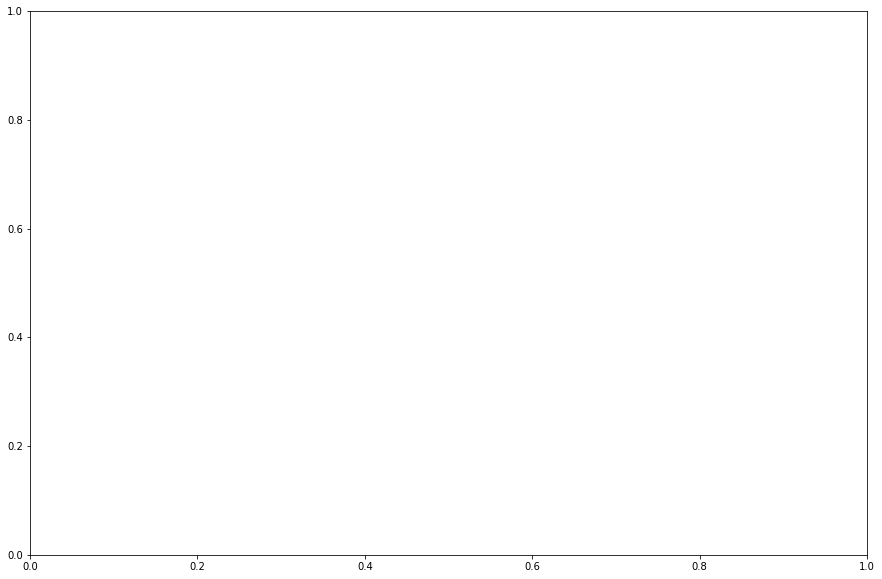

In [19]:
fig, ax = plt.subplots(figsize=(15,10))

importances = xgb_model.feature_importances_
features = X.columns
indicies = np.argsort(importances)
#fig.title("Feature importance")
slice_n = 15
ax.barh(range(len(indicies[:slice_n])), importances[indicies][:slice_n])

ax.set_title('Feature Importance', fontsize=26)
plt.style.use('bmh')
fig.patch.set_facecolor('black')
ax.yticks(range(len(indices)), [features[i] for i in indices])
fig.xlabel('Relative Importance')
#ax1.set_ylabel('Average Opening Revenue', fontsize=20)
#ax1.set_xlabel('MPAA Rating', fontsize=20)